# Natural Language Processing (NLP) e Unsupervised Machine Learning em E-Commerce

##### Este projeto aplica técnicas de Natural Language Processing (Processamento de Linguagem Natural) e Unsupervised Machine Learning (Aprendizado de Máquina Não Supervisionado) para identificar padrões em comentários negativos de plataformas de vendas brasileiras, agrupando textos semelhantes e extraindo tópicos relevantes.

Links para os modelos de machine learning e data set:
- K-Means: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- Latent Dirichlet Allocation (LDA): https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
- b2w Data Set: https://www.kaggle.com/code/abnerfreitas/nlp-buscape-data-ptbr-sentiment-analysis/input

## Extração e Representação do Corpus

#### Imports

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import spacy

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Criação do DataFrame e Separação do Corpus

In [2]:
# Carrega o dataset e remove linhas com valores NaN em qualquer coluna
df = pd.read_csv('b2w.csv').dropna()

# Filtra o dataframe para obter apenas os comentários classificados como negativos (polarity == 0)
corpus_negative = df.loc[df['polarity'] == 0]

# Seleciona apenas a coluna 'review_text', contendo os textos das avaliações negativas
corpus = corpus_negative['review_text']

#### Pré-Processamento do Corpus

In [3]:
# Carrega o modelo da língua portuguesa 'pt_core_news_lg' 
nlp = spacy.load('pt_core_news_lg', disable=["morphologizer", "senter", "attribute_ruler", "ner"]) # 'disable' desativa componentes que não serão utilizados no processamento de texto

# Lista de palavras irrelevantes para a análise, mas frequentes nos textos – nomes de lojas, verbos genéricos e palavras comuns que não agregam valor na criação de clusters e tópicos
additional_stop_words = {
    "produto", "comprei", "dia", "loja", "pra", "comprar", "compra", "hoje", "empresa", "americana", 
    "americanas", "polishop", "casas bahia", "casa bahia", "mercado livre", "ml", "site", "fastshop", 
    "amazon", "magazine luiza", "magalu", "recomendar", "conseguir", "ter", "já", "ja"
}

# Função de pré-processamento do corpus: lematiza os textos e remove stop-words
def preprocess(corpus):
  result = []

  for text in corpus.tolist():
    doc = nlp(text.lower()) # Converte para minúsculas
    tokens = [
      token.lemma_ # Obtém a forma lematizada da palavra
      for token in doc
      if token.is_alpha # Mantém apenas palavras (remove números e pontuações)
      and not token.is_stop # Garante que a palavra não está na lista padrão de stop-words de português do spaCy
      and token.lemma_ not in additional_stop_words # Garante que a palavra não está na lista adicional de stop-words
      ]
    
    result.append(' '.join(tokens).strip()) # Junta tokens em um único texto processado

  # Remove textos vazios antes de retornar
  return [text for text in result if text]

# Aplica o pré-processamento ao corpus original
corpus_preprocessed = preprocess(corpus)

# Mostra o tamanho e os primeiros exemplos do corpus original
print(len(corpus))
print(corpus[:3])

# Mostra o tamanho e os primeiros exemplos do corpus pré-processado
print(len(corpus_preprocessed))
print(corpus_preprocessed[:3])

35758
2     recebi o produto antes do prazo mas veio com d...
10    Não compra este produto, pois o mesmo veio com...
12    Tive azar, pois o produto não ligou. Tive que ...
Name: review_text, dtype: object
35741
['recebi prazo vir defeito trar ser resolver preciso', 'vir botão travar ligar ligar péssimo qualidade', 'azar ligar entregar fornecedor']


#### Representação de Texto com TF-IDF

In [4]:
# Instancia um vetorizador TF-IDF que converte textos em representações numéricas com pesos que refletem a importância dos termos (dentro de cada documento e em relação ao corpus inteiro)
vectorizer = TfidfVectorizer()

# Ajusta o vetorizador ao corpus pré-processado (aprende o vocabulário) e o transforma em uma matriz esparsa documento-termo
X_tfidf = vectorizer.fit_transform(corpus_preprocessed)

#### Representação de Texto com Bag-of-Words (BoW)

In [5]:
# Instancia um vetorizador Bag of Words (BoW) que converte textos em uma matriz baseada na contagem de palavras
extractor = CountVectorizer()

# Ajusta o vetorizador ao corpus pré-processado (aprende o vocabulário) e o transforma em uma matriz esparsa documento-termo
X_bow = extractor.fit_transform(corpus_preprocessed)

#### Exibição das Palavras Mais Frequentes

In [6]:
# Obtém as palavras do vocabulário aprendido pelo CountVectorizer
words = extractor.get_feature_names_out()

# Conta a frequência total de cada palavra no corpus
word_counts = np.asarray(X_bow.sum(axis=0)).flatten()

# Cria um dataframe associando cada palavra à sua respectiva frequência
df_words = pd.DataFrame({'word': words, 'count': word_counts})

# Define a quantidade de palavras mais frequentes a serem exibidas
words_amount = 50

# Ordena o dataframe em ordem decrescente de frequência e seleciona as 'words_amount' palavras mais comuns
top_words = df_words.sort_values(by='count', ascending=False).head(words_amount)

# Exibe as palavras mais frequentes e suas contagens
print(top_words)

            word  count
16463     recebi   7863
3459      chegar   5973
20339        vir   5754
7211    entregar   4595
7205     entrega   4477
13226        nao   4434
8467       ficar   3528
9028   funcionar   3454
17949        ser   3434
15602   problema   2992
16092  qualidade   2934
16009    péssimo   2856
10777         ir   2738
15345      prazo   2670
4473     contato   2630
911    americano   2487
1863     avaliar   2460
5192     defeito   2458
7586     esperar   2436
9417      gostar   2213
6142    dinheiro   2205
16462    receber   2150
7200      entrar   2068
1181    aparelho   1957
7271      enviar   1955
19867        uso   1950
19614      troca   1874
14469      pedir   1860
206        achar   1841
14060      outro   1823
17514       ruim   1813
8628         fiz   1757
14463     pedido   1754
3300     celular   1744
12032     mandar   1702
9658       haver   1660
5045         dar   1632
14360     passar   1561
17036   resolver   1553
8209       falar   1531
17097   resposta

#### Criação e Pré-Processamento do Texto para Teste

In [7]:
# Define um texto de teste para processamento
test_text = 'Ainda não recebi o produto. Vou cancelar a compra se não o receber até amanhã!'

# Converte a string para pd.Series, aplica a função 'preprocess' e reconverte para uma única string unindo os tokens processados
test_text = ' '.join(preprocess(pd.Series([test_text])))
print(test_text)

recebi ir cancelar receber amanhã


## Unsupervised Machine Learning

#### Clusterização de Documentos com K-Means

In [8]:
# Instancia o modelo K-Means para agrupamento de textos
kmeans = KMeans(n_clusters=3, max_iter=1000, random_state=42)
# n_clusters: define o número de clusters que o algoritmo deve encontrar
# max_iter: define o número máximo de iterações para convergência
# random_state: garante reprodutibilidade dos resultados

# Ajusta o modelo aos dados vetorizados pelo TF-IDF, aprendendo os centros dos clusters
kmeans.fit(X_tfidf)

KMeans(max_iter=1000, n_clusters=3, random_state=42)

In [9]:
# Transforma o texto de teste para a representação vetorizada TF-IDF
X_test = vectorizer.transform([test_text])

# Obtém o cluster atribuído ao documento pelo modelo K-Means
cluster_label = kmeans.predict(X_test)[0]

# Exibe o resultado do cluster atribuído ao documento de teste
print(f'O documento "{test_text}" pertence ao cluster {cluster_label}.\n')

# Exibe os primeiros documentos pertencentes ao mesmo cluster
print(f'Os primeiros documentos do cluster {cluster_label} são:')
count = 0
for i, text in enumerate(corpus):
  if kmeans.labels_[i] == cluster_label:
    print(f'- {text}')
    count += 1
    if count == 5:
      break

O documento "recebi ir cancelar receber amanhã" pertence ao cluster 0.

Os primeiros documentos do cluster 0 são:
- recebi o produto antes do prazo mas veio com defeito na trava ou seja não da para usar e até agora a Americanas não resolveu e preciso muito deste produto
- ainda não recebi meu produto, ainda estou aguardando o recebimento.
- Ainda nao recebi o produto então nao tenho como avaliar
- Fiz a compra desse produto no dia 21/02/2018 e até hoje 26/03/2018 não recebi, sendo assim não posso avaliar o produto como bom ou ruim, mas quanto ao fornecedor NÃO RECOMENDO!
- Não recebi o produto até agora vou comprar em outro lugar e colocar a americana na justiça  já foi pago a primeira  parcela


In [10]:
print("Documentos de outros clusters:\n")

# Número total de clusters no modelo K-Means
num_clusters = kmeans.n_clusters

# Percorre todos os clusters e imprime exemplos de cada, exceto do cluster atribuído ao texto de teste
for c in range(num_clusters):
    if c == cluster_label:
        continue  # Pula o cluster do documento testado
    print(f'Cluster {c}:')
    count = 0
    for i, text in enumerate(corpus):
        if kmeans.labels_[i] == c:
            print(f'- {text}')
            count += 1
            if count == 5:
                break
    print()

Documentos de outros clusters:

Cluster 1:
- Não compra este produto, pois o mesmo veio com os botões travados e ao tentar ligar o mesmo nem ligou. Péssima qualidade.
- Cancelei 10 minutos depois que efetuei a compra e me mandaram mesmo assim
- Na estação do som tudo correto mas a estalar os autuofalante não sai som.
- Balcão bonito. Entrega no prazo. Material frágil. Veio faltando parafusos para fixação do tampo, assim como faltou a proteção (cor preta) atrás do tampo, que aparece na imagem. Montagem fácil, mas o manual de instruções poderia ser mais completo. Não recomendo pela falta dos parafusos e da proteção.
- Bom dia não posso fazer avaliação, pois o produto foi incompatível para rodar no XBOX 360, não havia notado no rodapé da capa que tem que teria que ter o XBOX GOLD, tentei realizar a troca na loja física de Presidente Prudente mais não foi possível.

Cluster 2:
- Tive azar, pois o produto não ligou. Tive que entregar para o fornecedor.
- Uma enganação! Esperei quase um mês 

#### Visualização do K-Means por Meio de Redução de Dimensionalidade com Principal Component Analysis (PCA)

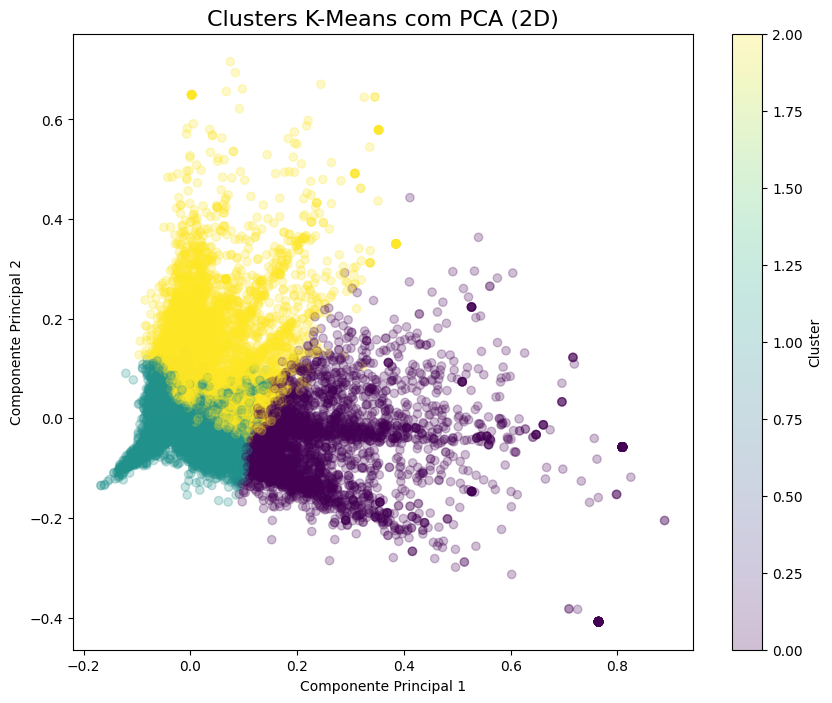

<Figure size 640x480 with 0 Axes>

In [11]:
# Instancia o modelo PCA para reduzir a dimensionalidade dos vetores TF-IDF para 2D
pca = PCA(n_components=2)
# n_components: define a quantidade de componentes principais a serem mantidos

# Aplica PCA aos vetores TF-IDF convertidos em array
X_reduced = pca.fit_transform(X_tfidf.toarray())
# fit_transform: ajusta o PCA aos dados e os transforma para a nova dimensionalidade

# Plota os clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.25)

# Adiciona título e rótulos
plt.title("Clusters K-Means com PCA (2D)", fontsize=16)
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Cluster")

# Exibe o gráfico
plt.show()
# Fecha o gráfico para liberar memória
plt.clf()

#### Extração de Tópicos com Latent Dirichlet Allocation (LDA)

In [12]:
# Instancia o modelo LDA para identificação de tópicos
lda = LDA(n_components=3, max_iter=20, random_state=42)
# n_components: define o número de tópicos que o modelo deve identificar no corpus
# max_iter: define o número máximo de iterações para a convergência do modelo
# random_state: garante reprodutibilidade dos resultados

# Ajusta o modelo aos dados vetorizados pelo BoW, aprendendo a distribuição dos tópicos
lda.fit(X_bow)

LatentDirichletAllocation(max_iter=20, n_components=3, random_state=42)

In [13]:
# Transforma o documento de teste usando o vetorizador BoW
X_test = extractor.transform([test_text])

# Obtém a distribuição de probabilidade do documento em relação aos tópicos extraídos pelo LDA
topic_probabilities = lda.transform(X_test)[0]

# Obtém os índices dos tópicos mais relevantes
top_topics = topic_probabilities.argsort()[::-1][-5:] # [-5:] mostra até 5 tópicos e [::-1] organiza em ordem decrescente

# Obtém o vocabulário aprendido pelo vetorizador BoW
word_index = extractor.get_feature_names_out()

print('Os tópicos que possuem maior compatibilidade com o documento de teste são:')
for topic in top_topics:

  # Seleciona as palavras mais importantes para o tópico (ordenadas por peso no modelo)
  frequent_words = lda.components_[topic].argsort()[-10:][::-1] # [-10:] mostra até 10 palavras e [::-1] organiza em ordem decrescente
  words = ', '.join([word_index[i] for i in frequent_words])

  # Exibe o tópico, sua probabilidade e suas palavras mais representativas
  print(f'- Tópico {topic} ({round((topic_probabilities[topic])*100, 1)}%) | Palavras principais do tópico: {words}')

Os tópicos que possuem maior compatibilidade com o documento de teste são:
- Tópico 2 (88.8%) | Palavras principais do tópico: recebi, chegar, entregar, entrega, prazo, nao, contato, avaliar, americano, receber
- Tópico 1 (5.6%) | Palavras principais do tópico: funcionar, aparelho, celular, problema, defeito, uso, vir, ficar, tv, bateria
- Tópico 0 (5.6%) | Palavras principais do tópico: vir, qualidade, ficar, péssimo, foto, peça, gostar, quebrar, ruim, achar


#### Visualização do LDA por Meio de Redução de Dimensionalidade com t-Distributed Stochastic Neighbor Embedding (t-SNE)

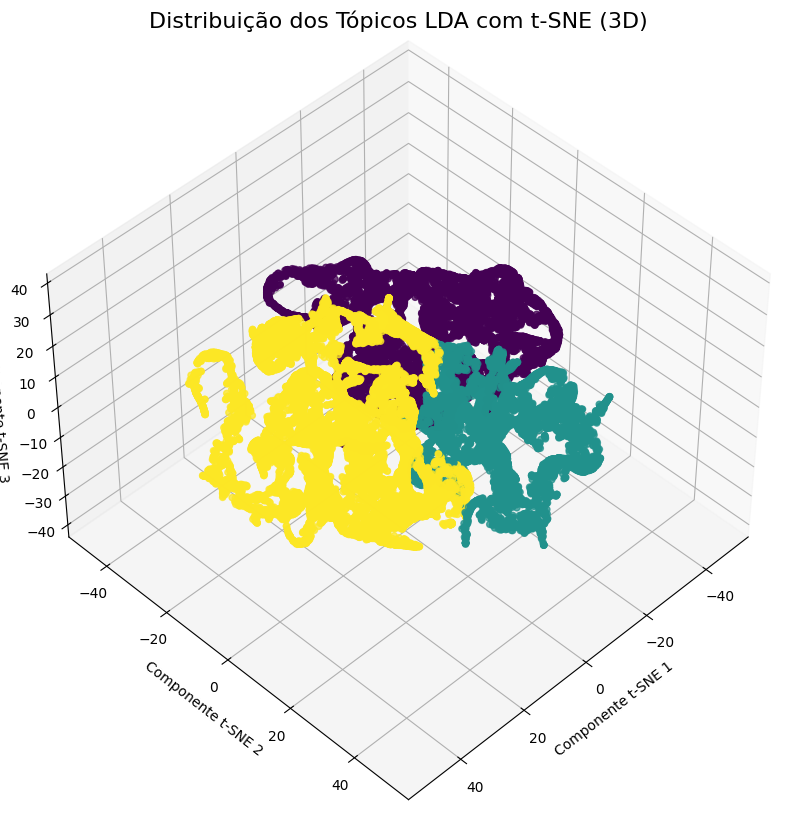

<Figure size 640x480 with 0 Axes>

In [14]:
# Obtém as distribuições de tópicos para todos os documentos
lda_topic_distributions = lda.transform(X_bow)

# Instancia o modelo t-SNE para reduzir a dimensionalidade dos tópicos para 3D
tsne = TSNE(n_components=3, random_state=42)
# n_components: reduz os dados para a dimensão inserida
# random_state: garante reprodutibilidade dos resultados

# Aplica t-SNE às distribuições de tópicos
X_tsne = tsne.fit_transform(lda_topic_distributions)

# Cria a figura para o gráfico 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Define o ângulo de visualização
ax.view_init(elev=45, azim=45)  # 45° de elevação e 45° de rotação horizontal

# Plota os documentos em 3D com base nos tópicos LDA
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=lda_topic_distributions.argmax(axis=1), cmap='viridis', alpha=0.75)

# Adiciona título e rótulos
ax.set_title("Distribuição dos Tópicos LDA com t-SNE (3D)", fontsize=16)
ax.set_xlabel("Componente t-SNE 1")
ax.set_ylabel("Componente t-SNE 2")
ax.set_zlabel("Componente t-SNE 3")

# Exibe o gráfico
plt.show()
# Fecha o gráfico para liberar memória
plt.clf()

#### Criação de DataFrame com Dados do K-Means e LDA

In [15]:
# Lista de clusters atribuídos a cada texto preprocessado do corpus pelo K-Means
cluster_kmeans = [kmeans.predict(vectorizer.transform([text]))[0] for text in corpus_preprocessed]

# Lista dos tópicos mais relevantes atribuídos a cada texto preprocessado do corpus pelo LDA
topics_lda = [lda.transform(extractor.transform([text]))[0].argmax() for text in corpus_preprocessed]

data = {
    "corpus_preprocessed": corpus_preprocessed,  # Lista de textos pré-processados
    "cluster_kmeans": cluster_kmeans,  # Número do cluster K-Means para cada texto
    "x_kmeans": X_reduced[:, 0],  # Primeira componente principal (PCA -> K-Means)
    "y_kmeans": X_reduced[:, 1],  # Segunda componente principal (PCA -> K-Means)
    "topic_lda": topics_lda,  # Número do tópico LDA para cada texto
    "x_tsne": X_tsne[:, 0],  # Primeira componente t-SNE (LDA)
    "y_tsne": X_tsne[:, 1],  # Segunda componente t-SNE (LDA)
    "z_tsne": X_tsne[:, 2],  # Terceira componente t-SNE (LDA)
}

# Cria o dataframe com as variáveis de interesse
df_kmeans_lda = pd.DataFrame(data)

# Exibe as primeiras linhas do dataframe
print(df_kmeans_lda.head())

# Salva o dataframe
df_kmeans_lda.to_csv("df_kmeans_lda.csv", index=False, encoding="utf-8")

                                 corpus_preprocessed  cluster_kmeans  \
0  recebi prazo vir defeito trar ser resolver pre...               0   
1     vir botão travar ligar ligar péssimo qualidade               1   
2                     azar ligar entregar fornecedor               2   
3  enganação esperar quase cancelar pedido contin...               2   
4                     cancelei minuto efetuei mandar               1   

   x_kmeans  y_kmeans  topic_lda     x_tsne     y_tsne     z_tsne  
0  0.113933 -0.068724          2  13.233377  13.479842  -2.710415  
1 -0.112458 -0.082285          1 -19.072109  10.596717   9.680546  
2 -0.016342  0.067936          2  14.758239  22.528944   2.490330  
3 -0.017848  0.025730          2  13.477225 -14.514805   0.576946  
4 -0.039041 -0.010241          2  16.039629  11.741956 -17.286251  
